# PyTorch básico 2: montando e treinando um modelo

Saindo de exemplos de regressão e indo para classificação vamos olhar agora para um dataset que tenta trazer o problema de veículos autônomos para um ambiente mais simples.

##  Classificação de imagens


Temos um pequeno robô andando numa pista feita de papel. O robô tem uma câmera frontal possibilitando que ele veja para onde ele está indo. Assim, dada uma imagem ele precisa saber que ação ele vai tomar: $\uparrow, \leftarrow, \rightarrow$. Queremos que o robô aprenda a andar na pista sozinho. 

Nós podemos tentar resolver esse problema como um problema de **aprendizado supervisionado** temos um dataset $(\mathbf{x}_{1}, y_{1}), \dots ,(\mathbf{x}_{N}, y_{N})$ onde $\mathbf{x}_i \in \mathbb{R}^{45\times 80 \times 3}$ é uma imagem e $y_i \in \{ \uparrow, \leftarrow, \rightarrow \}$ é um rótulo. Assim o problema de direção autônoma se resume em aprender uma função $f$ que associa para cada imagem uma distribuição de probabilidade sobre os rótulos.

<table>
<tr>
<td>
<img align="middle"   width='600' heith='100' src='images/image_classification.png'>
</td>
</tr>
</table>

Mais informações sobre esse problema você pode encontrar [aqui](https://medium.com/@project_m/self-drives-me-crazy-from-0-to-self-driving-car-in-150-hours-bf4f68d50d8a).


In [1]:
# notebook feito para a versão 0.4.0 do Pytorch 

import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from plots import plot9images, plot_histogram_from_labels
from util import randomize_in_place
% matplotlib inline
print("PyTorch version = {} ".format(torch.__version__))

PyTorch version = 0.4.0 


Em primeiro lugar vamos ter que pegar os dados

In [2]:
# Essa célula pode demorar de acordo com sua conexão de internet.
# Olhe o terminal para mais informações sobre o download
if not os.path.exists("self_driving_pi_car_data"):
    pro = subprocess.Popen(["bash", "download.sh"])
    pro.wait()

Nesse notebook vamos usar apenas um pedaço dos dados.

In [2]:
raw_X = np.load("self_driving_pi_car_data/train_data.npy")
raw_y = np.load("self_driving_pi_car_data/train_labels.npy")
randomize_in_place(raw_X, raw_y)
valid_X = raw_X[0:1000]
valid_y = raw_y[0:1000]
test_X = raw_X[1000:2000]
test_y = raw_y[1000:2000]
train_X = raw_X[2000:]
train_y = raw_y[2000:]

del raw_X
del raw_y

In [ ]:
tetst_X

In [3]:
command2int = {"forward": 0, "left": 1, "right": 2}
int2command = {i[1]: i[0] for i in command2int.items()}

print("Informações sobre os dados\n")
print("- Número de dados de treinamento = {}\n".format(train_X.shape[0]))
print("- Número de dados de validação = {}\n".format(valid_X.shape[0]))
print("- Número de dados de teste = {}\n".format(test_X.shape[0]))
print("- Número de features = {}\n".format(test_X.shape[1]))
print("- Número de classes = {}\n".format(3))
print("- Legenda das classes:  (0 = forward, 1 = left, 2 = right)\n")

Informações sobre os dados

- Número de dados de treinamento = 54172

- Número de dados de validação = 1000

- Número de dados de teste = 1000

- Número de features = 10800

- Número de classes = 3

- Legenda das classes:  (0 = forward, 1 = left, 2 = right)



### Olhando o dataset

Esses dados foram coletados fazendo com que o robô desse voltas nessa pista:

<table>
<tr>
<td>
<img align="middle" width='600' heith='100' src='images/train_track.png'>
</td>
</tr>
</table>

A cada ação tomada o robô tirava uma foto 45x80x3 (altura, largura, número de canais) e associava a ação tomada a essa foto.

As observações $\mathbf{x}_{1}, \dots, \mathbf{x}_{N}$ são as imagens transformadas em vetores (pegamos a matrix $45\times80\times3$ e a achatamos num vetor de tamanho $10800 = 45^*80^*3$). Cada feature aqui é a intensidade de um pixel da imagem (variando de 0 a 255).


Podemos olhar alguns exemplos: 

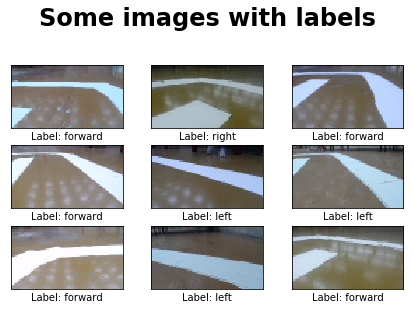

In [7]:
img9 = train_X[0:9]
labels9 = train_y[0:9]
labels9 = [int2command[i] for i in labels9]
img9 = img9.reshape((9, 45, 80, 3)) 
img9 = img9[...,::-1]
plot9images(img9, labels9, (45, 80, 3))

Também podemos olhar como estão as distribuição das classes nos diferentes conjuntos de dados

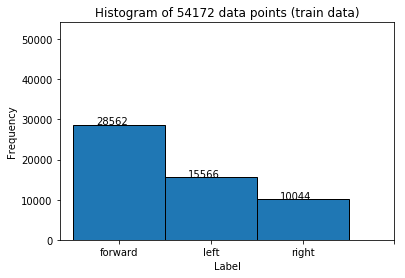

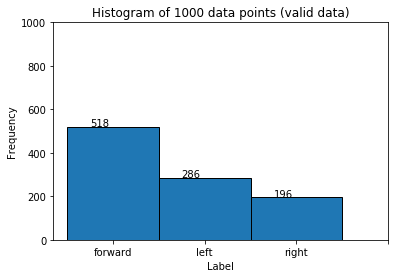

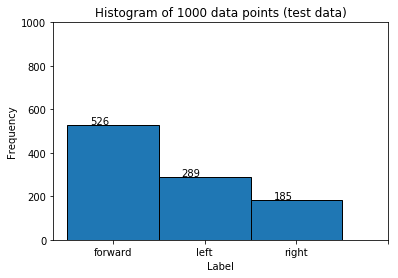

In [10]:
labels_legend = ["forward", "left", "right"]
plot_histogram_from_labels(train_y, labels_legend, "train data")
plot_histogram_from_labels(valid_y, labels_legend, "valid data")
plot_histogram_from_labels(test_y, labels_legend, "test data")

##  Organizando o código

Em primeiro lugar vamos criar uma classe para guardar todos os hiper parâmetros.

In [4]:
class LRConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 height=45,
                 width=80,
                 channels=3,
                 classes=3,
                 batch_size=32,
                 epochs=3,
                 save_step=100,
                 learning_rate=0.01,
                 momentum=0.1):
        self.height = height
        self.width = width
        self.classes = classes
        self.channels = channels
        self.batch_size = batch_size
        self.epochs = epochs
        self.save_step = save_step
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "classes = {}\n".format(self.classes)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "save_step = {}\n".format(self.save_step)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status


In [12]:
lr_config = LRConfig()
print("Os hiper parâmetros do modelo de regressão logística são:\n")
print(lr_config)

Os hiper parâmetros do modelo de regressão logística são:

height = 45
width = 80
channels = 3
classes = 3
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1



Vamos transformar as imagens em tensores e vamos usar a classe `TensorDataset` para guardar os dados.

In [13]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.Tensor(train_X),
                              torch.Tensor(train_y).type(torch.LongTensor))
valid_dataset = TensorDataset(torch.Tensor(valid_X),
                              torch.Tensor(valid_y).type(torch.LongTensor))
test_dataset = TensorDataset(torch.Tensor(test_X),
                              torch.Tensor(test_y).type(torch.LongTensor))

Para amostrar os dados vamos usar a classe `DataLoader` e vamos definir a classe `DataHolder` para exclusivamente lidar com os dados.

In [5]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                      batch_size=test_batch,
                                      shuffle=True)

Os diferentes dados de treinamento, teste e validação do nosso problema de carro autônomo vão ficar todos agrupados no objeto `self_driving_data`.


In [15]:
self_driving_data = DataHolder(lr_config, train_dataset, valid_dataset, test_dataset) 

Note que ao trabalharmos com imagens, nos dividimos um vetor de imagens por 255 para que o intervalo das features fique entre 0 e 1.

In [12]:
batch_X, batch_y = next(iter(self_driving_data.train_loader))
batch_X = batch_X / 255
print("exemplo de batch de treinamento\n")
print("batch_X")
print(batch_X)
print()
print("batch_X.type =", batch_X.type())
print()
print("batch_X.shape =", batch_X.shape)
print()
print("\nbatch_y")
print(batch_y)
print()
print("batch_y.type =", batch_y.type())
print()
print("batch_y.shape =", batch_y.shape)
print()

batch_X, batch_y = next(iter(self_driving_data.valid_loader))
batch_X = batch_X / 255
print("exemplo de batch de validação\n")
print("batch_X")
print(batch_X)
print()
print("batch_X.type =", batch_X.type())
print()
print("batch_X.shape =", batch_X.shape)
print()
print("\nbatch_y")
print(batch_y)
print()
print("batch_y.type =", batch_y.type())
print()
print("batch_y.shape =", batch_y.shape)
print()

exemplo de batch de treinamento

batch_X
tensor([[ 0.1961,  0.1451,  0.1294,  ...,  0.8078,  0.6627,  0.5843],
        [ 0.0627,  0.0510,  0.0392,  ...,  0.3490,  0.3882,  0.3882],
        [ 0.3176,  0.2980,  0.2902,  ...,  0.8235,  0.7333,  0.6353],
        ...,
        [ 0.1020,  0.1137,  0.1020,  ...,  0.6824,  0.6078,  0.5059],
        [ 0.1569,  0.2000,  0.2039,  ...,  0.8588,  0.7961,  0.7333],
        [ 0.2941,  0.2157,  0.1882,  ...,  0.3451,  0.3686,  0.4039]])

batch_X.type = torch.FloatTensor

batch_X.shape = torch.Size([32, 10800])


batch_y
tensor([ 0,  1,  0,  1,  0,  0,  1,  0,  1,  0,  1,  1,  1,  1,
         1,  0,  0,  1,  0,  0,  0,  2,  0,  0,  1,  0,  0,  0,
         1,  0,  0,  0])

batch_y.type = torch.LongTensor

batch_y.shape = torch.Size([32])

exemplo de batch de validação

batch_X
tensor([[ 0.1098,  0.1176,  0.1137,  ...,  0.2784,  0.3608,  0.3529],
        [ 0.2667,  0.2314,  0.2078,  ...,  0.1843,  0.2706,  0.2980],
        [ 0.1137,  0.0706,  0.0627,  ...

##  Definindo um modelo 1: regressão logística

Um modo conveniente de se definir modelos em PyTorch é feito usando a classe [`torch.nn.Module`](https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module). Nessa classe temos que definir apenas as operações na inicialização da classe e como o modelo vai realizar o *forward pass*.

###  **Exercício 4)**

Podemos definir um modelo de regressão logística do seguinte modo:

<table>
<tr>
<td>
<img align="middle"  width='600' heith='100' src='images/logistic_regression.png'>
</td>
</tr>
</table>




Complete a classe `LogisticRegression`.

Você deve definir a inicialização dessa classe e completar os métodos `forward` e `predict`. Note que:

 - o método `forward` deve retornar apenas os *logits*.
 
 - o método `predict` deve retornar $\mathbf{\hat{y}}$.


In [10]:
class LogisticRegression(nn.Module):
    """
    Logistic regression model.
    
    You may find nn.Linear and nn.Softmax useful here.
    
    :param config: hyper params configuration
    :type config: LRConfig
    """
    def __init__(self, config):
        super(LogisticRegression, self).__init__()
        # YOUR CODE HERE:
        self.config = config
        self.linear = nn.Linear(config.height*config.width*config.channels, config.classes)
        self.soft = nn.Softmax(1)
        # END YOUR CODE
        

    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: logits
        :rtype: torch.FloatTensor(shape=[batch_size, number_of_classes])
        """
        # YOUR CODE HERE:
        logits = self.linear(x)
        # END YOUR CODE
        return logits
    
    
    def predict(self, x):
        """
        Computes model's prediction

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: model's predictions
        :rtype: torch.LongTensor(shape=[batch_size, number_of_classes])
        """
        # YOUR CODE HERE:
        predictionsFloat = self.soft(self.forward(x))
        '''
        predictions = np.zeros(len(x))
        for i in range(len(x)):
            predictions[i] = (np.argmax(predictionsFloat[i].detach().numpy()))
            
        predictions = torch.from_numpy(predictions).long()'''
        
        predictions = torch.argmax(predictionsFloat, dim=1)
        
        # END YOUR CODE
        return predictions        

### Testes do exercío 4

In [14]:
lr_model = LogisticRegression(lr_config)
images = batch_X
out = lr_model(images)
assert out.type() == 'torch.FloatTensor', "problemas com o tipo da saida do método forward"
print(out.shape, torch.Size([lr_config.batch_size, lr_config.classes]))
assert out.shape == torch.Size([lr_config.batch_size, lr_config.classes]), "problemas com o shape da saida do método forward"

print(lr_model.parameters)

torch.Size([32, 3]) torch.Size([32, 3])
<bound method Module.parameters of LogisticRegression(
  (linear): Linear(in_features=10800, out_features=3, bias=True)
  (soft): Softmax()
)>


In [15]:
prediction = lr_model.predict(images)
print (prediction)
assert prediction.type() == 'torch.LongTensor', "problemas com o tipo da saida do método prediction"
assert prediction.shape == torch.Size([lr_config.batch_size]), "problemas com o shape da saida do método prediction"

tensor([ 0,  2,  2,  2,  2,  2,  0,  2,  0,  2,  0,  2,  2,  0,
         2,  2,  0,  0,  0,  2,  0,  2,  2,  0,  0,  0,  0,  2,
         0,  0,  0,  0])


Antes do treinamento podemos visualizar a qualidade das predições do modelo com os parâmetros randomicamente inicializados usando uma [matriz de confusão](https://en.wikipedia.org/wiki/Confusion_matrix)

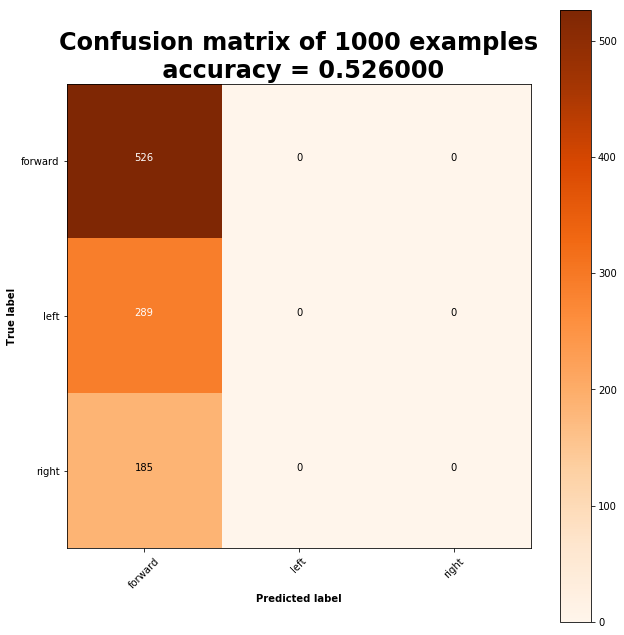

In [17]:
from plots import plot9images, plot_histogram_from_labels
import importlib
import plots
importlib.reload(plots)
img, labels = next(iter(self_driving_data.test_loader))

#tive que atualizar a batch_size do lr_config
lr_config.batch_size = 1000

lr_model = LogisticRegression(lr_config)
img = img / 255
pred = lr_model.predict(img)
pred = pred.numpy()



plots.plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred,
                      save=False,
                      path="logref_confusion_matrix.png",
                      classes=["forward", "left", "right"])

Temos os componentes principais para performar o treinamento:

- um modelo ('LogisticRegression')
- um dataset ('self_driving_data')
- um conjunto de hiper parâmetros ('LRConfig')

Agora basta criar um *loop* de treinamento. Vamos passar por todo o dataset um certo número de vezes (chamamos de *epoch* quando passamos por todo o dataset). A cada passagem vamos: 

- amostrar um batch de imagens e rótulos
- calcular a entropia cruzada entre os logits do modelo e os rótulos
- fazer o backward pass
- fazer a atualização dos pesos
- de tempos em tempos (dado pelo hiper parâmetro 'LRConfig.save_step'), vamos calcular o erro para o dataset de validação e vamos salvar os parâmetros do modelo quando vemos uma melhoria 

###  **Exercício 5)**

Você deve completar a função `train_model_img_classification`. Há 4 partes para ser completadas. Há um comentário em cada parte indicando o que deve ser feito.

In [6]:
def train_model_img_classification(model,
                                   config,
                                   dataholder,
                                   model_path,
                                   verbose=True):
    """
    Train a model for image classification

    :param model: image classification model
    :type model: LogisticRegression or DFN
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    train_loader = dataholder.train_loader
    valid_loader = dataholder.valid_loader

    best_valid_loss = float("inf")
    # YOUR CODE HERE:
    # i) define the loss criteria and the optimizer. 
    # You may find nn.CrossEntropyLoss and torch.optim.SGD useful here.
    
    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = config.learning_rate, momentum = config.momentum)

    valid_images, valid_labels = next(iter(valid_loader))
    
    # END YOUR CODE
    
    train_loss = []
    valid_loss = []
    for epoch in range(config.epochs):
        for step, (images, labels) in enumerate(train_loader):
            # YOUR CODE HERE:
            # ii) You should zero the model gradients
            # and define the loss function for the train data.
            optimizer.zero_grad()
            model.zero_grad()
            loss = criterion(model(images/255), labels)
            # is this loss?
            # END YOUR CODE
            if step % config.save_step == 0:
                # YOUR CODE HERE:
                # iii) You should define the loss function for the valid data.
                v_loss = criterion(model(valid_images/255), valid_labels)
                # END YOUR CODE
                valid_loss.append(float(v_loss))
                train_loss.append(float(loss))
                if float(v_loss) < best_valid_loss:
                    msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(loss),float(v_loss))
                    torch.save(model.state_dict(), model_path)
                    best_valid_loss = float(v_loss)
                    if verbose:
                        print(msg, end="")
            # YOUR CODE HERE:
            # iv) You should do the back propagation
            # and do the optimization step.
            # nem sei se isso ta certo:
            grad = loss.backward()
            optimizer.step()
            
            
            # END YOUR CODE
    if verbose:
        x = np.arange(1, len(train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, train_loss, label='train loss')
        ax.plot(x, valid_loss, label='valid loss')
        ax.legend()
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.title('Train and valid loss')
        plt.grid(True)
        plt.show()


### Testes do exercío 5

In [19]:
accuracy_list = []

for i in range(7):
    my_lr_config = LRConfig(epochs=1)
    my_lr_model = LogisticRegression(my_lr_config)
    train_model_img_classification(my_lr_model,
                                   my_lr_config,
                                   self_driving_data,
                                   'logreg.pkl',
                                   verbose=False)
    img, labels = next(iter(self_driving_data.test_loader))
    img = img / 255
    pred = my_lr_model.predict(img)
    pred = pred.numpy()
    accuracy = np.sum(pred == labels.numpy())/ labels.shape[0]
    accuracy_list.append(accuracy)
    print("i={}, accuracy = {:.3f}".format(i, accuracy))

assert os.path.exists("logreg.pkl"), "Problemas ao salvar o modelo"
assert np.mean(accuracy_list) >= 0.6, "A acurácia média tem que ser maior que 60%"

i=0, accuracy = 0.780
i=1, accuracy = 0.753
i=2, accuracy = 0.775
i=3, accuracy = 0.656
i=4, accuracy = 0.781
i=5, accuracy = 0.592
i=6, accuracy = 0.678


Agora podemos treinar o modelo de regressão logística

In [20]:
my_lr_config = LRConfig()
my_lr_model = LogisticRegression(my_lr_config)
train_model_img_classification(my_lr_model,
                               my_lr_config,
                               self_driving_data,
                               'logreg.pkl',
                               verbose=True)


train_loss = 1.034 | valid_loss = 1.004
train_loss = 1.258 | valid_loss = 1.001
train_loss = 0.457 | valid_loss = 0.870
train_loss = 0.691 | valid_loss = 0.767

KeyboardInterrupt: 

Olhando a matriz de confusão com o modelo treinado

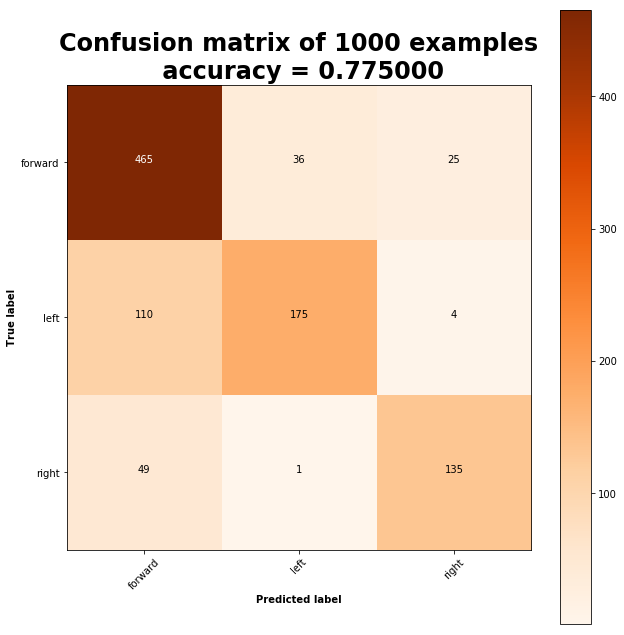

In [21]:
img, labels = next(iter(self_driving_data.test_loader))

my_lr_model = LogisticRegression(my_lr_config)

# aqui carregamos os parametros treinados do modelo
my_lr_model.load_state_dict(torch.load('logreg.pkl'))
img = img / 255
pred = my_lr_model.predict(img)
pred = pred.numpy()

plots.plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred,
                      save=False,
                      path="logref_confusion_matrix.png",
                      classes=["forward", "left", "right"])

Olhando alguns exemplos de classificação

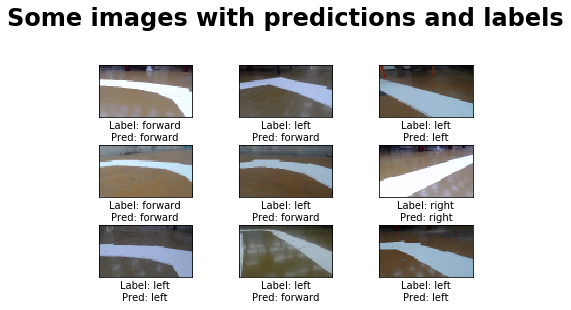

In [22]:
pred9 = pred[0:9]
pred9 = [int2command[i] for i in pred9] 
img9 = img[0:9].numpy()
labels9 = labels[0:9].numpy()
labels9 = [int2command[i] for i in labels9]
img9 = img9.reshape((9, 45, 80, 3))
img9 = img9[...,::-1]
plot9images(img9, labels9, (45, 80, 3), pred9)

##  Definindo um modelo 2: rede neural

*Deep Feedforward Networks* (DFN) são também chamadas de *feedforward neural
networks*, *multilayer perceptrons*, ou, em bom português, **redes neurais**.

Agora vamos implementar o modelo de rede neural. Como estamos estendendo a classe `nn.module` do PyTorch, definir uma rede neural não é muito mais complexo que definir um modelo de regressão logística.

Mas antes de definir o modelo, vamos construir uma classe para guardar todos os hiper parâmetros de uma rede neural.

In [8]:
class DFNConfig(LRConfig):
    """
    Holds DFN model hyperparams.

    :param architecture: network dense architecture
    :type architecture: list of int
    """
    def __init__(self, architecture=[100, 3]):
        super(DFNConfig, self).__init__()
        self.architecture = architecture

    def __str__(self):
        """
        Get all attributs values.

        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "architecture = {}\n".format(self.architecture)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "save_step = {}\n".format(self.save_step)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status


In [24]:
dfn_config = DFNConfig()
print("Os hiper parâmetros do modelo de rede neural são:\n")
print(dfn_config)

Os hiper parâmetros do modelo de rede neural são:

height = 45
width = 80
channels = 3
architecture = [100, 3]
batch_size = 32
epochs = 3
save_step = 100
learning_rate = 0.01
momentum = 0.1



## Exercicio 6: redes neurais profundas

<table>
<tr>
<td>
<img align="middle"  width='400' heith='100'  src='images/dfn.png'>
</td>
</tr>
</table>

Nesse exemplo, você vai ter que completar a classe `DFN`. 

Esssa classe instancia uma rede neural de acordo com o hiper parâmetro `config.architecture`. 

Assim, por exemplo, se `config.architecture = [200, 100, 3]`. Essa classe vai criar uma rede neural com duas camadas escondidas: uma com 200 neurônios e outra com 100 neurônios; e a camada de saída tem tamanho 3. Note que a camada de entrada deve ser criada usando `config.height`, `config.width` e `config.channels`.

Para simplificar a implementação, a não linearidade deve ser causada apenas pela função [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). Então, uma rede neural vai ser definida pelas fórmulas:

<table>
<tr>
<td>
<img align="middle"  width='350' heith='100'  src='images/dfn_description.png'>
</td>
</tr>
</table>





Como no caso da regressão logística, temos que:

 - o método `forward` deve retornar apenas os *logits* (os valores da última camada antes da aplicação da função softmax)
 
 - o método `predict` deve retornar $\mathbf{\hat{y}}$.

In [10]:
class DFN(nn.Module):
    """
    Deep Feedforward Network.
    
    The method self._modules is useful here.
    The class nn.ReLU() is useful too.
    
    :param config: hyper params configuration
    :type config: DFNConfig
    """
    def __init__(self, config):
        super(DFN, self).__init__()
        # YOUR CODE HERE:
        self.config = config
        inSize = config.height*config.width*config.channels
        layerList = []
        
        for i in config.architecture:
            layerList.append(nn.Linear(inSize, i))
            inSize = i
            
        self.layerList = nn.ModuleList(layerList)
        
        
        self.relu = nn.ReLU()
        self.macio = nn.Softmax(1)
        # END YOUR CODE


    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: logits
        :rtype: torch.FloatTensor(shape=[batch_size, number_of_classes])
        """
        logits = x
        # YOUR CODE HERE:
        for layer in self.layerList:
            logits = self.relu(layer(logits))
            
        # END YOUR CODE
        return logits
        
    
    def predict(self, x):
        """
        Computes model's prediction

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: model's predictions
        :rtype: torch.LongTensor(shape=[batch_size, number_of_classes])
        """
        # YOUR CODE HERE:
        predictionsFloat = self.macio(self.forward(x))
        
        predictions = torch.argmax(predictionsFloat, dim=1)
        # END YOUR CODE
        return predictions 


### Testes do exercío 6

In [11]:
dfn_config = DFNConfig()
dfn_model = DFN(dfn_config)
images = batch_X
out = dfn_model(images)
assert out.type() == 'torch.FloatTensor', "problemas com o tipo da saida do método forward"
assert out.shape == torch.Size([dfn_config.batch_size, dfn_config.classes]), "problemas com o shape da saida do método forward"

NameError: name 'batch_X' is not defined

In [27]:
prediction = dfn_model.predict(images)
assert prediction.type() == 'torch.LongTensor', "problemas com o tipo da saida do método forward"
assert prediction.shape == torch.Size([dfn_config.batch_size]), "problemas com o shape da saida do método forward"

In [28]:
def param_checker(config, model):
    """
    Check if the dfn model's has the right kind of parameters

    :param config: model's hyperparamters 
    :type config: DFNConfig
    :param model: neural network 
    :type model: DFN
    """
    input_shape = config.height * config.width * config.channels
    all_params = list(model.parameters())
    msg = "Modelo sem nenhum parâmetro"
    assert all_params != [], msg  
    architecture = [input_shape] + config.architecture
    count = 0
    for params in all_params:
        shape = tuple(params.shape)
        if len(shape) == 2:
            msgW = "{} != torch.Size([{}, {}])".format(params.shape, shape[0], shape[1]) 
            assert shape == (architecture[count + 1], architecture[count])  
        else:
            msgb = "{} != torch.Size([{}])".format(params.shape, shape[0]) 
            assert shape == (architecture[count + 1],)  
            count += 1
    print("Todos os parâmetros ok")



deep_config1 = DFNConfig(architecture=[400, 300, 200, 100, 50, 10])
deep_model1 = DFN(deep_config1)


deep_config2 = DFNConfig(architecture=[800, 600, 400, 300, 200, 100, 50, 27])
deep_model2 = DFN(deep_config2)


deep_config3 = DFNConfig(architecture=[900, 400, 300, 200, 100, 50, 13])
deep_model3 = DFN(deep_config3)

shallow_config = DFNConfig(architecture=[10])
shallow_model = DFN(shallow_config)

param_checker(deep_config1, deep_model1)
param_checker(deep_config2, deep_model2)
param_checker(deep_config3, deep_model3)
param_checker(shallow_config, shallow_model)

Todos os parâmetros ok
Todos os parâmetros ok
Todos os parâmetros ok
Todos os parâmetros ok


Vamos treinar uma rede neural com apenas duas camadas escondidas.


train_loss = 1.117 | valid_loss = 1.118
train_loss = 1.077 | valid_loss = 1.003
train_loss = 0.735 | valid_loss = 0.491
train_loss = 0.624 | valid_loss = 0.416
train_loss = 0.355 | valid_loss = 0.394
train_loss = 0.530 | valid_loss = 0.348
train_loss = 0.687 | valid_loss = 0.333
train_loss = 0.403 | valid_loss = 0.331
train_loss = 0.515 | valid_loss = 0.311
train_loss = 0.728 | valid_loss = 0.299
train_loss = 0.481 | valid_loss = 0.291
train_loss = 0.569 | valid_loss = 0.276
train_loss = 0.674 | valid_loss = 0.275
train_loss = 0.635 | valid_loss = 0.274
train_loss = 0.477 | valid_loss = 0.265
train_loss = 0.591 | valid_loss = 0.262
train_loss = 0.354 | valid_loss = 0.256
train_loss = 0.509 | valid_loss = 0.252
train_loss = 0.642 | valid_loss = 0.247

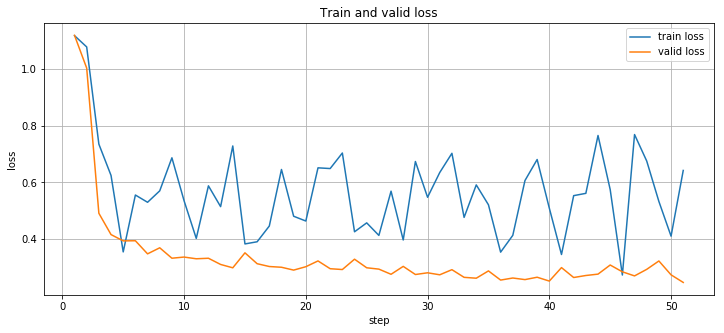

In [36]:
arch = [200, 100, 3]
#arch = [500, 300, 200, 3]

dfn_config = DFNConfig(architecture=arch)
dfn_model = DFN(dfn_config)
train_model_img_classification(dfn_model,
                               dfn_config,
                               self_driving_data,
                               'dfn.pkl',
                               verbose=True)

Como no caso da regressão logística podemos inspecionar o resultados do treinamento

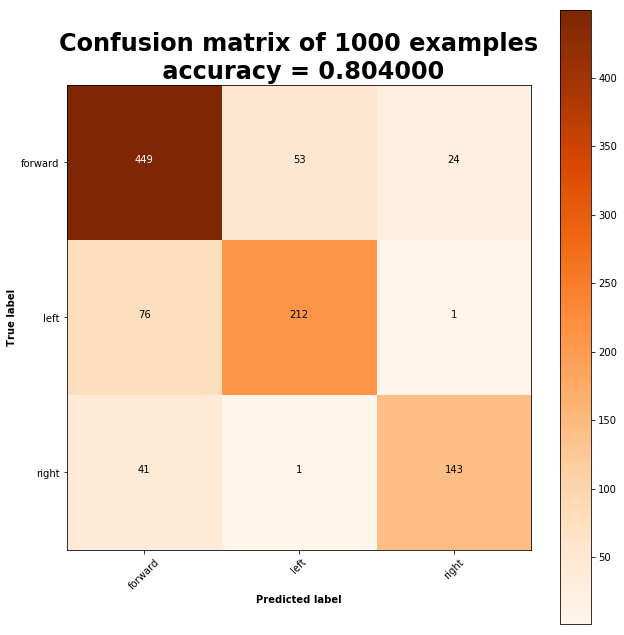

In [37]:
img, labels = next(iter(self_driving_data.test_loader))

dfn_config = DFNConfig(architecture=arch)
dfn_model = DFN(dfn_config)


dfn_model.load_state_dict(torch.load('dfn.pkl'))
img = img / 255
pred = dfn_model.predict(img)
pred = pred.numpy()

plots.plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred,
                      save=False,
                      path="dfn_confusion_matrix.png",
                      classes=["forward", "left", "right"])

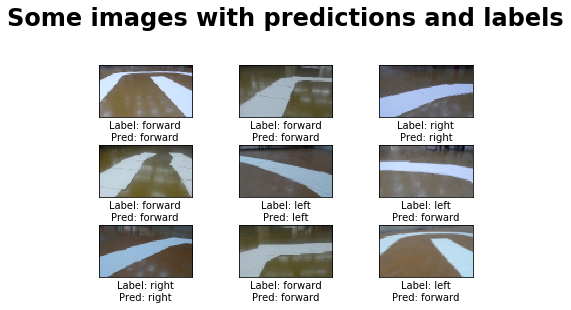

In [38]:
pred9 = pred[0:9]
pred9 = [int2command[i] for i in pred9] 
img9 = img[0:9].numpy()
labels9 = labels[0:9].numpy()
labels9 = [int2command[i] for i in labels9]
img9 = img9.reshape((9, 45, 80, 3))
img9 = img9[...,::-1]
plot9images(img9, labels9, (45, 80, 3), pred9)

Agora você pode treinar diferentes redes neurais com diferentes arquiteturas e ver qual é a melhor configuração para esse problema.

## Exercício 7: Competição no Kaggle

Uma vez treinado o modelo com os dados da pista de treinamento, temos que averiguar se o modelo consegue generalizar bem na pista de teste:

<table>
<tr>
<td>
<img align="middle" width='400' heith='100'  src='images/test_track.png'>
</td>
</tr>
</table>

As imagens dessa pista estão disponíveis na competição do Kaggle [MAC0460 self driving](https://www.kaggle.com/c/mac0460-self-driving). Há vários dados que não usamos da pasta 'self_driving_pi_car_data', é hora de usar todos eles! Agora você tem que usar todas as funções que você definiu até aqui e tentar treinar um modelo para a competição. Você pode usar outros modelos, outras bibliotecas e manipular os dados do jeito que achar melhor. 

Nesse último exercício você vai ter que treinar um modelo e submeter para a competição sua predição no formato [csv](https://en.wikipedia.org/wiki/Comma-separated_values). Você vai ter nota completa se você conseguir um resultado melhor que $0.?$ (to be announced).

A função abaixo ajuda a transformar um array de predições num csv. Boa competição!

In [23]:
def labels2csv(labels, csv_path):
    """
    Transform an array of labels into a csv file
    to be submitted on the kaggle competition
    https://www.kaggle.com/c/mac0460-self-driving

    :param labels: labels
    :type labels: np.array
    :param csv_path: path to save csv file
    :type csv_path: str
    """
    with open(csv_path, "w") as file:
        file.write("id,label\n")
        for i, label in enumerate(labels):
            file.write("{},{}\n".format(i,label))

In [31]:
testX = np.load("self_driving_pi_car_data/test_track_data.npy")
testXtensor = torch.Tensor(testX)
testXtensor = binarinator(testXtensor)

pred = dfn_model.predict(testXtensor)
pred = pred.numpy()

labels2csv(pred, "finalanswer_4.csv")


In [68]:
print(testXtensor)

KeyboardInterrupt: 

# NOW IT IS SERIOUS

In [25]:
arch = [200, 100 ,3]

dfn_config = DFNConfig(architecture= arch)
dfn_config.channels = 1
dfn_config.learning_rate = 0.01
dfn_config.batch_size = 64

lr_config = LRConfig(channels = 1)

In [3]:
gasjfks
def binarinator(tensor):
    return torch.sum(tensor.view([-1, 3])/3, dim=1).view([-1, 3600])

train_X2 = binarinator(torch.Tensor(train_X))
test_X2 = binarinator(torch.Tensor(test_X))
valid_X2 = binarinator(torch.Tensor(valid_X))
print(train_X2.shape)



torch.Size([54172, 3600])


In [17]:
print(train_X2.shape)
print(train_y.shape)
print(test_X2.shape)
print(test_y.shape)
print(valid_X2.shape)
print(valid_y.shape)
print(train_X2)

torch.Size([54172, 3600])
(54172,)
torch.Size([1000, 3600])
(1000,)
torch.Size([1000, 3600])
(1000,)
tensor([[  48.0000,   43.0000,   40.6667,  ...,  121.0000,  119.0000,
          118.0000],
        [  16.3333,   17.3333,   17.3333,  ...,   84.6667,   88.0000,
           86.3333],
        [  75.3333,   74.0000,   70.0000,  ...,  215.0000,  215.3333,
          214.6667],
        ...,
        [ 124.6667,  125.6667,  128.3333,  ...,   94.0000,   93.6667,
           94.0000],
        [  19.3333,   16.3333,   15.6667,  ...,   84.0000,   82.3333,
           81.0000],
        [   8.6667,   10.6667,   14.3333,  ...,   78.0000,   78.6667,
           80.6667]])


In [26]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(torch.Tensor(train_X2),
                              torch.Tensor(train_y).type(torch.LongTensor))
valid_dataset = TensorDataset(torch.Tensor(valid_X2),
                              torch.Tensor(valid_y).type(torch.LongTensor))
test_dataset = TensorDataset(torch.Tensor(test_X2),
                              torch.Tensor(test_y).type(torch.LongTensor))


train_loss = 1.083 | valid_loss = 1.094
train_loss = 0.797 | valid_loss = 0.737
train_loss = 0.620 | valid_loss = 0.562
train_loss = 0.553 | valid_loss = 0.501
train_loss = 0.647 | valid_loss = 0.480
train_loss = 0.572 | valid_loss = 0.476
train_loss = 0.622 | valid_loss = 0.463
train_loss = 0.805 | valid_loss = 0.463
train_loss = 0.506 | valid_loss = 0.455
train_loss = 0.521 | valid_loss = 0.453
train_loss = 0.541 | valid_loss = 0.449
train_loss = 0.678 | valid_loss = 0.441
train_loss = 0.584 | valid_loss = 0.428

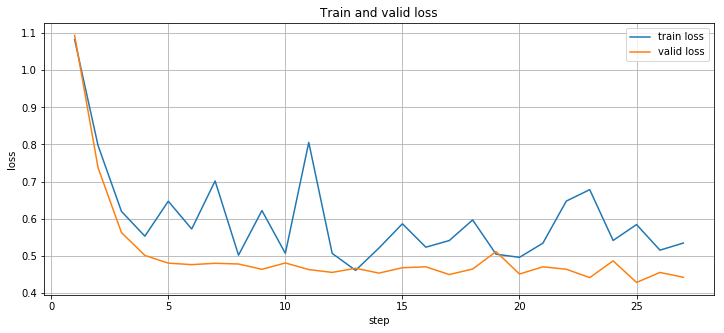

In [29]:
self_driving_data = DataHolder(dfn_config, train_dataset, valid_dataset, test_dataset)





dfn_model = DFN(dfn_config)
train_model_img_classification(dfn_model,
                               dfn_config,
                               self_driving_data,
                               'dfn.pkl',
                               verbose=True)

In [16]:
img, labels = next(iter(self_driving_data.test_loader))

dfn_config = DFNConfig(architecture=arch)
dfn_model = DFN(dfn_config)


dfn_model.load_state_dict(torch.load('dfn.pkl'))
img = img / 255
pred = dfn_model.predict(img)
pred = pred.numpy()

plots.plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred,
                      save=False,
                      path="dfn_confusion_matrix.png",
                      classes=["forward", "left", "right"])

RuntimeError: Error(s) in loading state_dict for DFN:
	While copying the parameter named "layerList.0.weight", whose dimensions in the model are torch.Size([200, 10800]) and whose dimensions in the checkpoint are torch.Size([200, 3600]).

In [31]:
print(train_X2[0])

tensor([  48.0000,   43.0000,   40.6667,  ...,  121.0000,  119.0000,
         118.0000])
